# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.10 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
       # print(actions)
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
     #   print(rewards)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

In [5]:
%load_ext autoreload
%autoreload 2
import time
import importlib
import maddpg_agent
from maddpg_agent import Agent
import numpy as np
import torch
import random
from collections import namedtuple, deque
from torch.autograd import Variable 
import matplotlib.pyplot as plt

In [6]:
def maddpg(n_episode=2000):
    print("state_size",state_size)
    print("action_size", action_size)
    scores = [];
    score_window = deque(maxlen=100);
    avg_score_100 = []
    best_avg = -np.inf
    for i_episode in range(n_episode):
        env_info = env.reset(train_mode=True)[brain_name]
        states = np.reshape(env_info.vector_observations, (1, num_agents*state_size))
        start_time = time.time()
        score = np.zeros(num_agents) 
        agent_1.reset()
        agent_2.reset()
        while(True):
            actions_0 = agent_1.act(states, add_noise=True)
            actions_1 = agent_2.act(states, add_noise=True)
            actions = np.concatenate((actions_0, actions_1), axis=0).flatten()
            env_info = env.step(actions)[brain_name]
            next_states = np.reshape(env_info.vector_observations, (1,num_agents*state_size))
            dones = env_info.local_done
            rewards = env_info.rewards
            agent_1.step(states, actions, rewards[0], next_states, dones, 0)
            agent_2.step(states, actions, rewards[1], next_states, dones, 1)
            states = next_states
            score = score+np.max(rewards)
            if(np.any(dones)):
                break
        scores.append(np.max(score))
        score_window.append(scores[-1])
        avg_score_100.append(np.mean(score_window)) 
        eclipse_time = time.time()-start_time
        if(i_episode%10==0):
             print("\rEpisode {} ({} sec) \t Score: {:.2f} \t Average last 100 epoch score: {:.2f}".format(i_episode, round(eclipse_time), np.max(scores[-10:]), avg_score_100[-1], end=""))
        if(avg_score_100[-1]>0.5 and scores[-1]>best_avg):
            best_avg = scores[-1]
            torch.save(agent_1.actor_local.state_dict(), 'agent1_checkpoint_actor.pth')
            torch.save(agent_1.critic_local.state_dict(), 'agent1_checkpoint_critic.pth')
            torch.save(agent_2.actor_local.state_dict(), 'agent2_checkpoint_actor.pth')
            torch.save(agent_2.critic_local.state_dict(), 'agent2_checkpoint_critic.pth')
        if(i_episode>=1500 and avg_score_100[-1]>0.8):
            break
            
    return scores, avg_score_100



In [7]:
agent_1 = Agent(state_size, action_size, random_seed=0)
agent_2 = Agent(state_size, action_size, random_seed=0)

state_size 24
action_size 2
Episode 0 (0 sec) 	 Score: 0.00 	 Average last 100 epoch score: 0.00
Episode 10 (0 sec) 	 Score: 0.00 	 Average last 100 epoch score: 0.00
Episode 20 (0 sec) 	 Score: 0.00 	 Average last 100 epoch score: 0.00
Episode 30 (0 sec) 	 Score: 0.00 	 Average last 100 epoch score: 0.00
Episode 40 (0 sec) 	 Score: 0.00 	 Average last 100 epoch score: 0.00
Episode 50 (1 sec) 	 Score: 0.10 	 Average last 100 epoch score: 0.00
Episode 60 (0 sec) 	 Score: 0.00 	 Average last 100 epoch score: 0.00
Episode 70 (0 sec) 	 Score: 0.00 	 Average last 100 epoch score: 0.00
Episode 80 (0 sec) 	 Score: 0.00 	 Average last 100 epoch score: 0.00
Episode 90 (0 sec) 	 Score: 0.20 	 Average last 100 epoch score: 0.00
Episode 100 (0 sec) 	 Score: 0.00 	 Average last 100 epoch score: 0.00
Episode 110 (0 sec) 	 Score: 0.00 	 Average last 100 epoch score: 0.00
Episode 120 (0 sec) 	 Score: 0.20 	 Average last 100 epoch score: 0.01
Episode 130 (0 sec) 	 Score: 0.10 	 Average last 100 epoch s

Episode 1150 (5 sec) 	 Score: 2.00 	 Average last 100 epoch score: 0.40
Episode 1160 (2 sec) 	 Score: 2.50 	 Average last 100 epoch score: 0.43
Episode 1170 (6 sec) 	 Score: 1.40 	 Average last 100 epoch score: 0.46
Episode 1180 (3 sec) 	 Score: 1.20 	 Average last 100 epoch score: 0.43
Episode 1190 (1 sec) 	 Score: 5.10 	 Average last 100 epoch score: 0.52
Episode 1200 (2 sec) 	 Score: 1.00 	 Average last 100 epoch score: 0.52
Episode 1210 (2 sec) 	 Score: 1.00 	 Average last 100 epoch score: 0.49
Episode 1220 (2 sec) 	 Score: 1.00 	 Average last 100 epoch score: 0.51
Episode 1230 (2 sec) 	 Score: 0.80 	 Average last 100 epoch score: 0.54
Episode 1240 (2 sec) 	 Score: 0.80 	 Average last 100 epoch score: 0.55
Episode 1250 (4 sec) 	 Score: 0.90 	 Average last 100 epoch score: 0.53
Episode 1260 (3 sec) 	 Score: 1.00 	 Average last 100 epoch score: 0.52
Episode 1270 (8 sec) 	 Score: 1.80 	 Average last 100 epoch score: 0.51
Episode 1280 (6 sec) 	 Score: 2.60 	 Average last 100 epoch scor

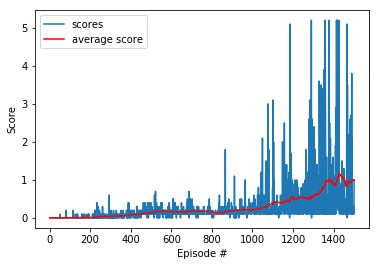

In [8]:
from workspace_utils import active_session
with active_session():
    scores, ave_score_100 = maddpg()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(1, len(scores)+1), scores, label='scores')
    plt.plot(np.arange(1, len(ave_score_100)+1), ave_score_100, c='r', label='average score')
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.legend(loc='upper left');
    plt.show()

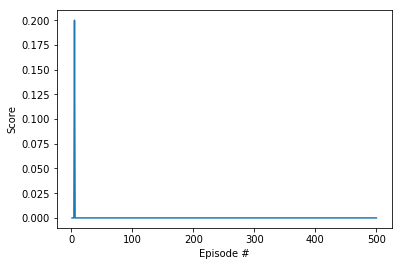

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label='scores')
plt.plot(np.arange(1, len(ave_score_100)+1), ave_score_100, c='r', label='average score')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()



### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [13]:
test = [[2,3],[4,5]]

In [17]:
test=np.zeros(1,2)

TypeError: data type not understood

In [16]:
test[:,2:]

TypeError: list indices must be integers or slices, not tuple

In [36]:
a = torch.randn(1,2)
b = torch.randn(1,2)

In [37]:
torch.cat((a,b),dim=1)

tensor([[ 1.2007, -1.0763,  1.4955, -0.5748]])

In [38]:
a

tensor([[ 1.2007, -1.0763]])

In [19]:
actions = np.random.randn(2,2)

In [20]:
actions

array([[ 1.2180169 , -1.20127092],
       [-0.1493464 , -1.2886375 ]])

In [21]:
actions[:,:2]

array([[ 1.2180169 , -1.20127092],
       [-0.1493464 , -1.2886375 ]])

array([[-0.1493464, -1.2886375]])

array([[ 1.2180169 , -1.20127092],
       [-0.1493464 , -1.2886375 ]])